# Classifcation of Amazon Product Page HTML Nodes


In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from tqdm import tqdm

import torch
from torch import nn
from transformers import (
    AlbertModel,
    AlbertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import sys

sys.path.insert(1, "..")
from TextClassificationDataset import TextClassificationDataset
from BERTClassifier import BERTClassifier

c:\Users\timashan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data


In [2]:
base_data_path = "../../data/I-created/amazon-scrape-4-llm/"
df_train = pd.read_csv(base_data_path + "amazon.csv")
df_test = pd.read_csv(base_data_path + "laptops.csv")

train_texts, train_labels = df_train.to_dict("list").values()
val_texts, val_labels = df_test.to_dict("list").values()

In [5]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(
        actual_labels, predictions
    )

In [6]:
def train(model, data_loader, optimizer, scheduler, device):
    losses = []
    model.train()
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
    return losses

In [7]:
def predict(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return preds.item()

In [8]:
bert_model_name = "albert/albert-base-v2"
n_classes = 2
max_length = 128
batch_size = 16
n_epochs = 4
learning_rate = 2e-5

m = AlbertModel.from_pretrained(bert_model_name)
tokenizer = AlbertTokenizer.from_pretrained(bert_model_name)
train_dataloader = TextClassificationDataset(
    train_texts, train_labels, tokenizer, max_length
).to_loader(shuffle=True)
val_dataloader = TextClassificationDataset(
    val_texts, val_labels, tokenizer, max_length
).to_loader()

In [9]:
losses = []
train_accuracies = []
val_accuracies = []
lrs = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(m, n_classes).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=2e-3)
total_steps = len(train_dataloader) * n_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [10]:
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    losses += train(model, train_dataloader, optimizer, scheduler, device)
    train_accuracy, train_report = evaluate(model, train_dataloader, device)
    val_accuracy, report = evaluate(model, val_dataloader, device)
    train_accuracies.extend([train_accuracy] * len(train_dataloader))
    val_accuracies.extend([val_accuracy] * len(train_dataloader))
    lrs.append(optimizer.param_groups[0]["lr"])
    print(
        f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, loss: {losses[-1]}"
    )

Epoch 1/4


100%|██████████| 30/30 [00:07<00:00,  3.75it/s]


Train Accuracy: 0.9120, Val Accuracy: 0.9156, loss: 0.11898918449878693
Epoch 2/4


100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


Train Accuracy: 0.9549, Val Accuracy: 0.9355, loss: 0.07367318868637085
Epoch 3/4


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Train Accuracy: 0.9614, Val Accuracy: 0.9355, loss: 0.033584367483854294
Epoch 4/4


100%|██████████| 30/30 [00:07<00:00,  3.84it/s]


Train Accuracy: 0.9721, Val Accuracy: 0.9454, loss: 0.0239710733294487


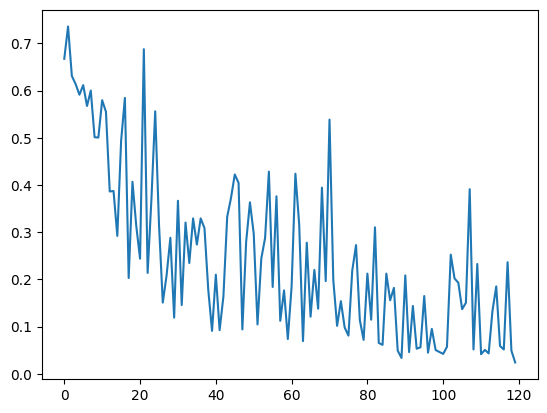

In [11]:
plt.plot(range(len(losses)), losses)

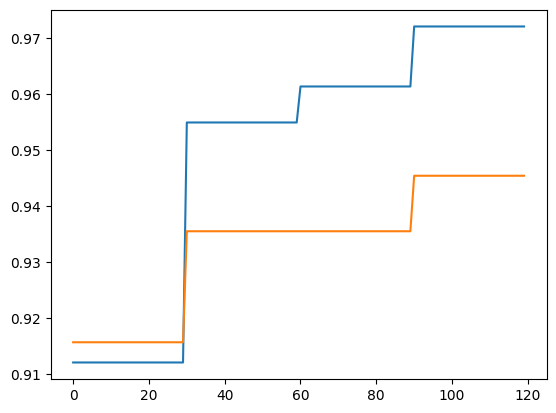

In [12]:
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(train_accuracies)), val_accuracies)

In [17]:
sum([p.nelement() for p in m.parameters()])

11683584

## ML


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from transformers import pipeline

In [185]:
X_train = tokenizer(
    train_texts,
    return_tensors="pt",
    max_length=max_length,
    padding="max_length",
    truncation=True,
)["input_ids"]

X_test = tokenizer(
    val_texts,
    return_tensors="pt",
    max_length=max_length,
    padding="max_length",
    truncation=True,
)["input_ids"]


nb = GaussianNB().fit(X_train, train_labels)
accuracy_score(nb.predict(X_test), val_labels)

0.6054590570719603